In [1]:
from model import DenoisingUNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch.nn as nn
import torch
sampleRate = 49.95

## Train - Val - Test sets

In [2]:
train_path = "train-events"
val_path = "val-events"
train_files = glob(os.path.join(train_path, '*.npy'))
val_files = glob(os.path.join(val_path, '*.npy'))

## Hyperparameters

In [3]:
N_sub = 32
batch_size = 32
hidden_layers = 6
learning_rate = 5e-6
num_epochs = 30

## Datasets and DataLoaders

In [4]:
train_dataset = mask_dataset(data_path='train-events', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [5]:
val_dataset = mask_dataset(data_path='validation-events', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [6]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

# model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
# model.to(device)
# Load model trained at synthetic data
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/synthetic-train-1085.pth')
model.load_state_dict(state['model_state_dict'])
model.train()
model.to(device)
# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


## Training

In [7]:
epochs_losses_train = []
epochs_losses_val = []
cc_gainz = []
for epoch in range(num_epochs):
    batch_losses = []
    ## TRAIN ##
    for eval_samples, mask in train_loader:
        # to GPU
        mask = mask.to(device)
        eval_samples = eval_samples.to(device)
        # apply mask
        sample = eval_samples * mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)
        # complementary mask
        c_mask = (1-mask).squeeze()

        optimizer.zero_grad()
        # apply complementary mask to output (proj. operator)
        output = model(sample).squeeze()*c_mask
        truth = (eval_samples.squeeze()*c_mask).squeeze()
        loss = criterion(output.squeeze(), truth)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for eval_samples, mask in val_loader:
            # to GPU
            mask = mask.to(device)
            eval_samples = eval_samples.to(device)
            # apply mask
            sample = eval_samples * mask.clone().detach()
            sample = torch.unsqueeze(sample.squeeze(), 1)
            # complementary mask
            c_mask = (1-mask).squeeze()

            optimizer.zero_grad()
            # apply complementary mask to output (proj. operator)
            output = model(sample).squeeze()*c_mask
            truth = (eval_samples.squeeze()*c_mask).squeeze()
            loss = criterion(output.squeeze(), truth)
        eval_losses.append(loss.item())
        epochs_losses_val.append(np.mean(eval_losses))
        #### TRY TESTING MODEL TO SEE MEAN CC GAIN.
        og = np.array(eval_samples.detach().cpu())
        rec = np.array(output.detach().cpu())
        bin_size = 5
        cc_og = compute_moving_coherence(og, bin_size)
        cc_rec = compute_moving_coherence(rec, bin_size)
        cc_gain = cc_rec / cc_og
        cc_gainz.append(np.mean(cc_gain))
        print(f"Epoch: {epoch} Train Loss: {np.mean(batch_losses)}, Val Loss: {np.mean(eval_losses)}, Avg CC Gain: {np.mean(cc_gain)}")
    model.train()

Epoch: 0 Train Loss: 0.020746727269142867, Val Loss: 0.018142297863960266, Avg CC Gain: 14.59956735016139
Epoch: 1 Train Loss: 0.015088438931852579, Val Loss: 0.012194441631436348, Avg CC Gain: 14.467954550635898
Epoch: 2 Train Loss: 0.011608127833654483, Val Loss: 0.01126742735505104, Avg CC Gain: 15.040299049948516
Epoch: 3 Train Loss: 0.009462445958827932, Val Loss: 0.014151680283248425, Avg CC Gain: 10.76882432833142
Epoch: 4 Train Loss: 0.00808206952487429, Val Loss: 0.008184865117073059, Avg CC Gain: 15.84901691133608
Epoch: 5 Train Loss: 0.00715562637274464, Val Loss: 0.011273286305367947, Avg CC Gain: 15.530764382292048
Epoch: 6 Train Loss: 0.006514945734913151, Val Loss: 0.011413858272135258, Avg CC Gain: 13.55772013529668
Epoch: 7 Train Loss: 0.006051131181108455, Val Loss: 0.008685479871928692, Avg CC Gain: 10.091421841841328
Epoch: 8 Train Loss: 0.005690825187290708, Val Loss: 0.0073445700109004974, Avg CC Gain: 13.388264705456873
Epoch: 9 Train Loss: 0.005403030584566295, 

Text(0.5, 1.0, 'Validation MSE')

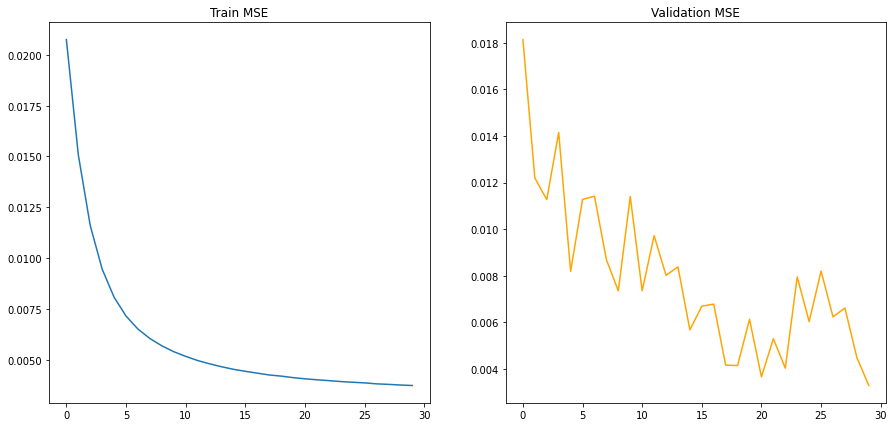

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(epochs_losses_train)
# ax1.set_yscale("log") 
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val, 'orange')
ax2.set_title("Validation MSE")


In [9]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "C:\\Users\\nikos\\Desktop\\denoising\\new_model_tests\\yo30.pth")


In [10]:
# from time import sleep
# sleep(60*2)
# os.system("shutdown -l")
